In [1]:
import tensorflow as tf
import numpy as np
from copy import deepcopy
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [10]:
learning_rate = 0.001
training_iters = 200000
batch_size = 16
disp_freq = 100

n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75

x = tf.placeholder(tf.float32, [None, n_input])
y_ = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

In [40]:

def conv2d(x,w,b,strides=1):
    x = tf.nn.conv2d(x,w,strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x,b)
    return tf.nn.relu(x)

def maxpool(x,k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')

class Model:


    def __init__(self, x, y_,dropout):

        w1 = tf.Variable(tf.random_normal([5, 5, 1, 32]))
        w2 = tf.Variable(tf.random_normal([5, 5, 32, 64]))
        w3 = tf.Variable(tf.random_normal([7*7*256,1024]))
        wout = tf.Variable(tf.random_normal([1024, n_classes]))
        b1 = tf.Variable(tf.random_normal([32]))
        b2 = tf.Variable(tf.random_normal([64]))
        b3 = tf.Variable(tf.random_normal([1024]))
        bout = tf.Variable(tf.random_normal([n_classes]))
       

        x = tf.reshape(x, shape=[-1, 28, 28, 1])
        conv1 = conv2d(x, w1, b1)
        print w1.get_shape().as_list()[0]
        pool1 = maxpool(conv1,k=2)
        conv2 = conv2d(pool1,w2,b2)
        print w2.get_shape().as_list()
        pool2 = maxpool(conv2,k=2)
        print w3.get_shape().as_list()
        print conv2
        fc1 = tf.reshape(conv2, [-1, w3.get_shape().as_list()[0]])
        print fc1
        fc1 = tf.add(tf.matmul(fc1, w3), b3)
        fc1 = tf.nn.relu(fc1)
        fc1 = tf.nn.dropout(fc1, dropout)
        out = tf.add(tf.matmul(fc1, wout), bout)
        self.x = x
        self.y = out
        self.var_list=[w1,w2,w3,wout,b1,b2,b3,bout]
        
        self.cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=self.y))
        self.set_vanilla_loss()
        correct_prediction = tf.equal(tf.argmax(self.y,1), tf.argmax(y_,1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
    def compute_fisher(self, imgset, sess, num_samples=200, plot_diffs=False, disp_freq=10):
        # computer Fisher information for each parameter

        # initialize Fisher information for most recent task
        self.F_accum = []
        for v in range(len(self.var_list)):
            self.F_accum.append(np.zeros(self.var_list[v].get_shape().as_list()))

        # sampling a random class from softmax
        probs = tf.nn.softmax(self.y)
        class_ind = tf.to_int32(tf.multinomial(tf.log(probs), 1)[0][0])

        if(plot_diffs):
            # track differences in mean Fisher info
            F_prev = deepcopy(self.F_accum)
            mean_diffs = np.zeros(0)

        for i in range(num_samples):
            # select random input image
            im_ind = np.random.randint(imgset.shape[0])
            # compute first-order derivatives
            ders = sess.run(tf.gradients(tf.log(probs[0,class_ind]), self.var_list), feed_dict={self.x: imgset[im_ind:im_ind+1]})
            # square the derivatives and add to total
            for v in range(len(self.F_accum)):
                self.F_accum[v] += np.square(ders[v])
            if(plot_diffs):
                if i % disp_freq == 0 and i > 0:
                    # recording mean diffs of F
                    F_diff = 0
                    for v in range(len(self.F_accum)):
                        F_diff += np.sum(np.absolute(self.F_accum[v]/(i+1) - F_prev[v]))
                    mean_diff = np.mean(F_diff)
                    mean_diffs = np.append(mean_diffs, mean_diff)
                    for v in range(len(self.F_accum)):
                        F_prev[v] = self.F_accum[v]/(i+1)
                    plt.plot(range(disp_freq+1, i+2, disp_freq), mean_diffs)
                    plt.xlabel("Number of samples")
                    plt.ylabel("Mean absolute Fisher difference")
                    display.display(plt.gcf())
                    display.clear_output(wait=True)

        # divide totals by number of samples
        for v in range(len(self.F_accum)):
            self.F_accum[v] /= num_samples
    
    def set_vanilla_loss(self):
        self.train_step = tf.train.GradientDescentOptimizer(0.1).minimize(self.cross_entropy)

    def star(self):
    # used for saving optimal weights after most recent task training
        self.star_vars = []
        for v in range(len(self.var_list)):
            self.star_vars.append(self.var_list[v].eval())
    def update_ewc_loss(self, lam):
        # elastic weight consolidation
        # lam is weighting for previous task(s) constraints

        if not hasattr(self, "ewc_loss"):
            self.ewc_loss = self.cross_entropy

        for v in range(len(self.var_list)):
            self.ewc_loss += (lam/2) * tf.reduce_sum(tf.multiply(self.F_accum[v].astype(np.float32),tf.square(self.var_list[v] - self.star_vars[v])))
        self.train_step = tf.train.GradientDescentOptimizer(0.1).minimize(self.ewc_loss)
 
    def restore(self, sess):
    # reassign optimal weights for latest task
        if hasattr(self, "star_vars"):
            for v in range(len(self.var_list)):
                sess.run(self.var_list[v].assign(self.star_vars[v]))



In [42]:

model = Model(x, y_,dropout)
print model.getVarList()
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

5
[5, 5, 32, 64]
[12544, 1024]
Tensor("Relu_33:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("Reshape_53:0", shape=(?, 12544), dtype=float32)
8


In [19]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [20]:
def mnist_imshow(img):
    plt.imshow(img.reshape([28,28]), cmap="gray")
    plt.axis('off')

def permute_mnist(mnist):
    perm_inds = range(mnist.train.images.shape[1])
    np.random.shuffle(perm_inds)
    mnist2 = deepcopy(mnist)
    sets = ["train", "validation", "test"]
    for set_name in sets:
        this_set = getattr(mnist2, set_name) # shallow copy
        this_set._images = np.transpose(np.array([this_set.images[:,c] for c in perm_inds]))
    return mnist2

def plot_test_acc(plot_handles):
    plt.legend(handles=plot_handles, loc="center right")
    plt.xlabel("Iterations")
    plt.ylabel("Test Accuracy")
    plt.ylim(0,1)
    display.display(plt.gcf())
    display.clear_output(wait=True)


In [51]:
def train_task(model, num_iter, disp_freq, trainset, testsets, x, y_, lams=[0]):
    for l in range(len(lams)):
        # lams[l] sets weight on old task(s)
        model.restore(sess) # reassign optimal weights from previous training session
        if(lams[l] == 0):
            model.set_vanilla_loss()
        else:
            model.update_ewc_loss(lams[l])
        # initialize test accuracy array for each task 
        test_accs = []
        for task in range(len(testsets)):
            test_accs.append(np.zeros(num_iter/disp_freq))
        # train on current task
        step = 0
        for iter in range(num_iter):
            batch = trainset.train.next_batch(batch_size)
            model.train_step.run(feed_dict={x: batch[0], y_: batch[1]})
            if (iter % disp_freq == 0):
                plt.subplot(1, len(lams), l+1)
                plots = []
                colors = ['r', 'b', 'g']
                for task in range(len(testsets)):
                    feed_dict={x: testsets[task].test.images, y_: testsets[task].test.labels}
                    test_accs[task][iter/disp_freq] = model.accuracy.eval(feed_dict=feed_dict)
                    c = chr(ord('A') + task)
                    plot_h, = plt.plot(range(1,iter+2,disp_freq), test_accs[task][:iter/disp_freq+1], colors[task], label="task " + c)
                    plots.append(plot_h)
                plot_test_acc(plots)
                if l == 0: 
                    plt.title("sgd")
                else:
                    plt.title("ewc")
                plt.gcf().set_size_inches(len(lams)*5, 3.5)

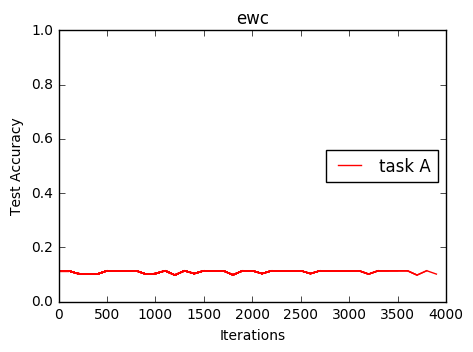

In [52]:
train_task(model, 4000, 100, mnist, [mnist], x, y_, lams=[0])